In [31]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [32]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.model

importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd)

from endoutbreakvbd import eop_analytical, eop_simulation, renewal_model
from endoutbreakvbd.chikungunya import get_parameters

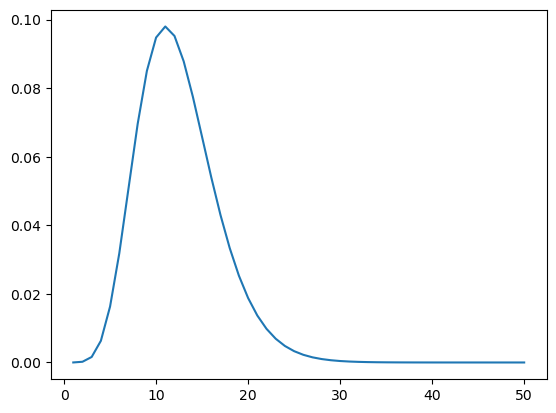

In [ ]:
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]
rng = np.random.default_rng(2)

plt.plot(range(1, len(gen_time_dist_vec) + 1), gen_time_dist_vec)

In [35]:
rep_no_max = 2
rep_no_min = 0
doy_min = 0  # Jan 1


def rep_no_func_doy(doy):
    return 0.5 * (
        rep_no_max
        + rep_no_min
        - (rep_no_max - rep_no_min) * np.cos(2 * np.pi * (doy - doy_min) / 365)
    )


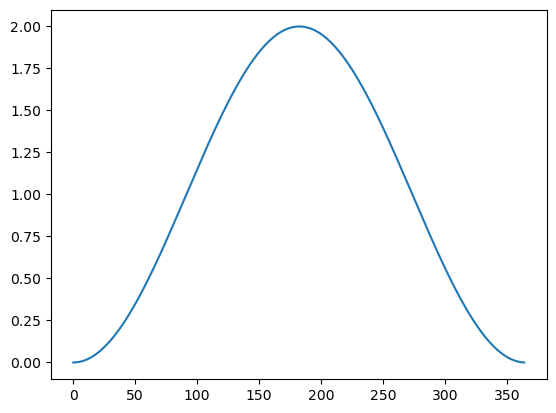

In [36]:
plt.plot(rep_no_func_doy(np.arange(0, 365)))

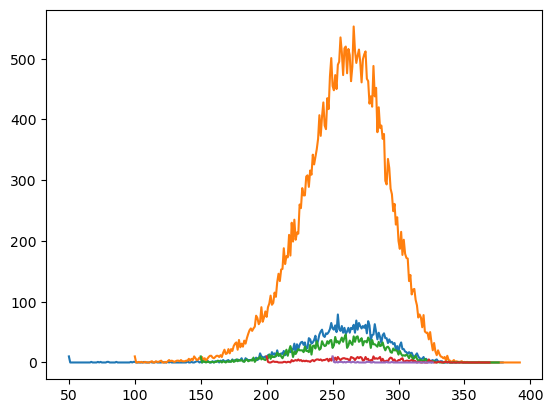

In [37]:
for doy_start in [50, 100, 150, 200, 250]:
    incidence_vec = renewal_model(
        rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
        t_stop=1000,
        gen_time_dist_vec=gen_time_dist_vec,
        rng=rng,
        incidence_init=10,
    )
    plt.plot(
        np.arange(doy_start, doy_start + len(incidence_vec)),
        incidence_vec,
    )

100%|██████████| 46/46 [00:02<00:00, 20.32it/s]


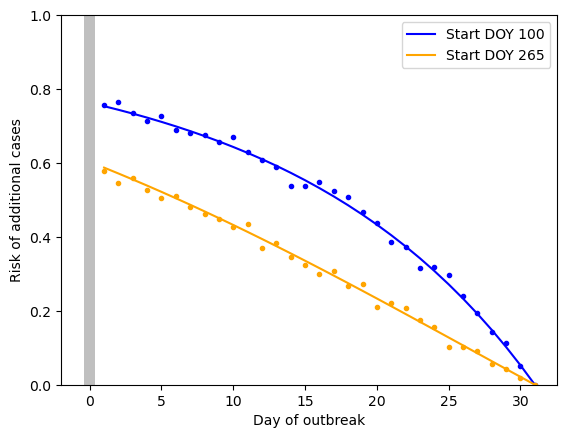

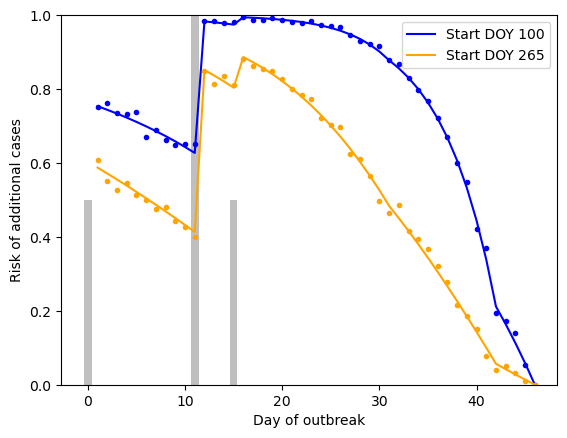

In [38]:
for incidence_vec in [[1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1]]:
    plt.figure()
    plt.bar(
        np.arange(len(incidence_vec)),
        incidence_vec / np.max(incidence_vec),
        color="gray",
        alpha=0.5,
    )
    for doy_start, color in zip([100, 265], ["blue", "orange"]):
        eop_days = np.arange(1, len(incidence_vec) + len(gen_time_dist_vec) + 1)
        eop_vals = np.zeros_like(eop_days, dtype=float)
        for eop_day_idx, eop_day in enumerate(eop_days):
            eop_vals[eop_day_idx] = eop_analytical(
                incidence_vec=incidence_vec,
                rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
                gen_time_dist_vec=gen_time_dist_vec,
                t_calc=eop_day,
            )
        plt.plot(eop_days, 1 - eop_vals, label=f"Start DOY {doy_start}", color=color)
        eop_days_sim = np.arange(1, len(incidence_vec) + len(gen_time_dist_vec) + 1)
        eop_vals_sim = np.zeros_like(eop_days_sim, dtype=float)
        for eop_day_idx, eop_day in enumerate(tqdm(eop_days_sim)):
            eop_vals_sim[eop_day_idx] = eop_simulation(
                incidence_vec=incidence_vec,
                rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
                gen_time_dist_vec=gen_time_dist_vec,
                t_calc=eop_day,
                n_sims=1000,
                rng=rng,
            )
        plt.plot(eop_days_sim, 1 - eop_vals_sim, ".", color=color)
        plt.ylim(0, 1)
        plt.xlabel("Day of outbreak")
        plt.ylabel("Risk of additional cases")
        plt.legend()

In [39]:
len(gen_time_dist_vec)

30